In [1]:
import pandas as pd
import numpy as np

from ProcessingFunctions.ImputingMissingValues import fill_values_with_swaps
from ProcessingFunctions.TrainingDataProcessing import creating_joint_df, create_processed_training_df

from sklearn.preprocessing import MinMaxScaler

import pickle
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

## Get Data

In [2]:
train_home_team_statistics_df = pd.read_csv('Train_Data/train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('Train_Data/train_away_team_statistics_df.csv', index_col=0)



train_home = train_home_team_statistics_df.iloc[:,2:] # i.e. we drop the league and team name 
train_away = train_away_team_statistics_df.iloc[:,2:]

train_home.columns = 'HOME_' + train_home.columns # We do this so that we can combine the data sets into one for training
train_away.columns = 'AWAY_' + train_away.columns

train_data =  pd.concat([train_home,train_away],join='inner',axis=1) # Join together

train_scores = pd.read_csv('Train_Data/Y_train.csv', index_col=0)
train_scores = train_scores.loc[train_data.index] # This is our target

In [3]:
train_scores.head()
# train_scores.describe()

HOME_WINS  DRAW  AWAY_WINS
ID                            
0           0     0          1
1           0     1          0
2           0     0          1
3           1     0          0
4           0     1          0

This, along with some helper functions will allow us to select the columns that we need easily

In [4]:
column_titles = ['TEAM_ATTACKS',
                'TEAM_BALL_POSSESSION', # Doesn't have a sum
                'TEAM_BALL_SAFE',
                'TEAM_CORNERS',
                'TEAM_DANGEROUS_ATTACKS',
                'TEAM_FOULS',
                'TEAM_GAME_DRAW', # Keep in absolute value
                'TEAM_GAME_LOST', # Keep in absolute value
                'TEAM_GAME_WON', # Keep in absolute value
                'TEAM_GOALS',
                'TEAM_INJURIES', # Keep in absolute value
                'TEAM_OFFSIDES',
                'TEAM_PASSES',
                'TEAM_PENALTIES',
                'TEAM_REDCARDS',
                'TEAM_SAVES',
                'TEAM_SHOTS_INSIDEBOX',
                'TEAM_SHOTS_OFF_TARGET',
                'TEAM_SHOTS_ON_TARGET',
                'TEAM_SHOTS_OUTSIDEBOX',
                'TEAM_SHOTS_TOTAL',
                'TEAM_SUBSTITUTIONS',
                'TEAM_SUCCESSFUL_PASSES',
                'TEAM_SUCCESSFUL_PASSES_PERCENTAGE', # Doesn't have a sum
                'TEAM_YELLOWCARDS'
                ]

## Data Exploration 

First lets get an overview of the different columns

In [5]:
train_scores.describe()

HOME_WINS          DRAW     AWAY_WINS
count  12303.000000  12303.000000  12303.000000
mean       0.435341      0.258961      0.305698
std        0.495822      0.438082      0.460721
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000
50%        0.000000      0.000000      0.000000
75%        1.000000      1.000000      1.000000
max        1.000000      1.000000      1.000000

So about 44% are wins, 25% draws and 30% losses. If we can include draws in this, we should be able to improve our predictions.

For later use, we will print all the column names

In [6]:
types = train_data.dtypes
for i, c in enumerate(train_data.columns):
    print(c)

HOME_TEAM_SHOTS_TOTAL_season_sum
HOME_TEAM_SHOTS_INSIDEBOX_season_sum
HOME_TEAM_SHOTS_OFF_TARGET_season_sum
HOME_TEAM_SHOTS_ON_TARGET_season_sum
HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum
HOME_TEAM_PASSES_season_sum
HOME_TEAM_SUCCESSFUL_PASSES_season_sum
HOME_TEAM_SAVES_season_sum
HOME_TEAM_CORNERS_season_sum
HOME_TEAM_FOULS_season_sum
HOME_TEAM_YELLOWCARDS_season_sum
HOME_TEAM_REDCARDS_season_sum
HOME_TEAM_OFFSIDES_season_sum
HOME_TEAM_ATTACKS_season_sum
HOME_TEAM_PENALTIES_season_sum
HOME_TEAM_SUBSTITUTIONS_season_sum
HOME_TEAM_BALL_SAFE_season_sum
HOME_TEAM_DANGEROUS_ATTACKS_season_sum
HOME_TEAM_INJURIES_season_sum
HOME_TEAM_GOALS_season_sum
HOME_TEAM_GAME_WON_season_sum
HOME_TEAM_GAME_DRAW_season_sum
HOME_TEAM_GAME_LOST_season_sum
HOME_TEAM_SHOTS_TOTAL_season_average
HOME_TEAM_SHOTS_INSIDEBOX_season_average
HOME_TEAM_SHOTS_OFF_TARGET_season_average
HOME_TEAM_SHOTS_ON_TARGET_season_average
HOME_TEAM_SHOTS_OUTSIDEBOX_season_average
HOME_TEAM_PASSES_season_average
HOME_TEAM_SUCCESSFUL_PASS

### Missing Values

We now want to check what is missing

In [7]:
def check_missing(df, should_print = True):
    n_data = len(df)
    frac_missing = []
    for c in df.columns:
        if df[c].isnull().sum() != 0:
            frac_missing.append((c, 100*df[c].isnull().sum()/n_data))


    frac_missing.sort(key = lambda x : x[1], reverse = True)
    if should_print:
        print(f"Total frac missing: {0.01 * sum((frac[1] for frac in frac_missing))/(len(df.columns))}")
        for i, pair in enumerate(frac_missing):
            print(i, pair)
    return frac_missing
    

Okay, so most of the columns have missing values. I want to figure out what are the most important variables. But first lets try to tidy up some of those values. I guess there are two things to be done:
- We could use the missing away data to fill in the missing home data. However I only think this makes sense for the injuries data
- We could use the last 5 match data as an estimate for the seasons data and vice versa (maybe check that they map onto each other). 

We will write a useful function that will allow us to fill in any missing values with those. 

In [8]:
# def fill_values_with_swaps(df, col1, col2):
#     df[col1] = df[col1].fillna(df[col2])
#     df[col2] = df[col2].fillna(df[col1])

In [9]:

def compare_imputation_error_with_copying(season, last_5):
    '''
    This function calculates the error in estimating a value by the mean or mode or by using the value in a differnt column.
    If the last number printed is smallest, it means that our best estimate is due to taking the value. 
    '''
    print("------------------------")
    print(season, last_5)
    df_comp = train_data.dropna(subset=[last_5, season])
    mean_5, mean_season = df_comp[last_5].mean(), df_comp[season].mean()
    mode_5, mode_season = df_comp[last_5].mode(), df_comp[season].mode()
    
    last = df_comp[last_5].to_numpy()
    seas = df_comp[season].to_numpy()
    length = len(df_comp)
    
    print(f"Last 5 error with mean: {np.sum(np.absolute(last-mean_5))/length}")
    print(f"Season error with mean: {np.sum(np.absolute(seas-mean_season))/length}")
    
    print(f"Last 5 error with mode: {np.sum(np.absolute(last-mode_5[0]))/length}")
    print(f"Season error with mode: {np.sum(np.absolute(seas-mode_season[0]))/length}")
    
    print(f"Season - last 5: {np.sum(np.absolute(seas-last))/length}")
    print(length)
    print("------------------------\n")


In [10]:
compare_imputation_error_with_copying('HOME_TEAM_INJURIES_5_last_match_std', 'HOME_TEAM_INJURIES_season_std')
compare_imputation_error_with_copying('HOME_TEAM_INJURIES_5_last_match_sum', 'HOME_TEAM_INJURIES_season_sum')

compare_imputation_error_with_copying('HOME_TEAM_PASSES_5_last_match_std', 'HOME_TEAM_PASSES_season_std')
compare_imputation_error_with_copying('HOME_TEAM_PASSES_5_last_match_sum', 'HOME_TEAM_PASSES_season_sum')

------------------------
HOME_TEAM_INJURIES_5_last_match_std HOME_TEAM_INJURIES_season_std
Last 5 error with mean: 2.282415687556922
Season error with mean: 2.2376246319145032
Last 5 error with mode: 2.3402337228714525
Season error with mode: 2.236950473010573
Season - last 5: 2.075459098497496
8985
------------------------

------------------------
HOME_TEAM_INJURIES_5_last_match_sum HOME_TEAM_INJURIES_season_sum
Last 5 error with mean: 2.418026715764678
Season error with mean: 2.399436565064759
Last 5 error with mode: 2.8520968946750616
Season error with mode: 2.7024863941948563
Season - last 5: 1.8896595880909188
9371
------------------------

------------------------
HOME_TEAM_PASSES_5_last_match_std HOME_TEAM_PASSES_season_std
Last 5 error with mean: 2.280384050861106
Season error with mean: 2.2891548130288517
Last 5 error with mode: 2.2596602576068694
Season error with mode: 2.3142617136456973
Season - last 5: 1.974892663804368
10714
------------------------

--------------------

It is much better to predict the value with the last_5 or season estimate, rather than use a mean/mode imputation. I guess the way to proceed is as follows:
1. Fill in missing values using the swapping idea
2. Where appropriate fill in more missing values by comparing home and away statistics

#### Filling with season/last_5

In [11]:
train_home_col_sum = [c for c in train_home.columns if c.split('_')[-1] == 'sum']
train_home_col_std = [c for c in train_home.columns if c.split('_')[-1] == 'std']

train_home_col_sum_season = [c for c in train_home_col_sum if c.split('_')[-2] == 'season']
train_home_col_sum_last_5 = [c for c in train_home_col_sum if c.split('_')[-2] == 'match']

train_home_col_std_season = [c for c in train_home_col_std if c.split('_')[-2] == 'season']
train_home_col_std_last_5 = [c for c in train_home_col_std if c.split('_')[-2] == 'match']

#### Injury Missing Values

We will deal with the injury missing values as well

In [12]:
fill_values_with_swaps(train_data, 'HOME_TEAM_INJURIES_5_last_match_std', 'AWAY_TEAM_INJURIES_5_last_match_std')
fill_values_with_swaps(train_data, 'HOME_TEAM_INJURIES_5_last_match_average', 'AWAY_TEAM_INJURIES_5_last_match_average')
fill_values_with_swaps(train_data, 'HOME_TEAM_INJURIES_5_last_match_sum', 'AWAY_TEAM_INJURIES_5_last_match_sum')
# check_missing(train_data); 

HOME_TEAM_SHOTS_TOTAL_season_sum  HOME_TEAM_SHOTS_INSIDEBOX_season_sum  \
ID                                                                              
0                                   3.0                                   2.0   
1                                   6.0                                   8.0   
2                                   4.0                                   2.0   
3                                   7.0                                   5.0   
4                                   3.0                                   3.0   
...                                 ...                                   ...   
12298                               4.0                                   2.0   
12299                               4.0                                   2.0   
12300                               4.0                                   3.0   
12301                               2.0                                   NaN   
12302                               2.0                                   3.0   

       HOME_TEAM_SHOTS_OFF_TARGET_season_sum  \
ID                                             
0                                        5.0   
1                                        3.0   
2                                        5.0   
3                                        5.0   
4                                        2.0   
...                                      ...   
12298                                    3.0   
12299                                    3.0   
12300                                    5.0   
12301                                    1.0   
12302                                    1.0   

       HOME_TEAM_SHOTS_ON_TARGET_season_sum  \
ID                                            
0                                       2.0   
1                                       6.0   
2                                       2.0   
3                                       6.0   
4                                       3.0   
...                                     ...   
12298                                   4.0   
12299                                   1.0   
12300                                   3.0   
12301                                   1.0   
12302                                   2.0   

       HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum  HOME_TEAM_PASSES_season_sum  \
ID                                                                          
0                                        1.0                          2.0   
1                                        5.0                          8.0   
2                                        8.0                          1.0   
3                                        6.0                          9.0   
4                                        4.0                          4.0   
...                                      ...                          ...   
12298                                    7.0                          4.0   
12299                                    5.0                          1.0   
12300                                    5.0                          1.0   
12301                                    NaN                          NaN   
12302                                    2.0                          3.0   

       HOME_TEAM_SUCCESSFUL_PASSES_season_sum  HOME_TEAM_SAVES_season_sum  \
ID                                                                          
0                                         2.0                         5.0   
1                                         7.0                        10.0   
2                                         1.0                         2.0   
3                                         9.0                         2.0   
4                                         3.0                         4.0   
...                                       ...                         ...   
12298                                     4.0                         3.0   
12299                

Okay, so this doesn't really do as much as I would have liked. I think we are now getting to the point where we just need to impute the missing values

#### Filling the leftovers

We are just going to fill the rest with the mean value

In [13]:
train_data = train_data.fillna(train_data.mean())
train_home = train_home.fillna(train_home.mean())
train_away = train_away.fillna(train_away.mean())

### Data Visualisation 

Lets have a look at how different data corresponds with the home team winning:

In [14]:
def plot_means_and_err(cols, title,data_frame):
# Plot the mean and standard error for each column
    x_vals = [' '.join(s.split('_')[2:4]) for s in cols]
    plt.figure(figsize=(12, 8))
    
    for i in ["HOME_WINS", "DRAW", "AWAY_WINS"]:
        mean_values = data_frame[train_scores[i] == 1][cols].mean()
        std_values = data_frame[cols].std()
        num_samples = len(cols)
        std_error = std_values / (num_samples ** 0.5)  # Standard error = standard deviation / sqrt(number of samples)
                  
        plt.errorbar(x_vals, mean_values, yerr=std_error, fmt ='o', alpha = 0.8, label = i, capsize = 5)
        
    plt.xlabel('Columns')
    plt.ylabel('Mean')
    plt.legend()
    plt.title(title)
    plt.xticks(rotation=90)
    plt.grid(axis='y')
    plt.show()

#### Home Data

We could probably tidy this into a column

In [15]:
train_home_col_sum = [c for c in train_home.columns if c.split('_')[-1] == 'sum']
train_home_col_std = [c for c in train_home.columns if c.split('_')[-1] == 'std']

train_home_col_sum_season = [c for c in train_home_col_sum if c.split('_')[-2] == 'season']
train_home_col_sum_last_5 = [c for c in train_home_col_sum if c.split('_')[-2] == 'match']

train_home_col_std_season = [c for c in train_home_col_std if c.split('_')[-2] == 'season']
train_home_col_std_last_5 = [c for c in train_home_col_std if c.split('_')[-2] == 'match']

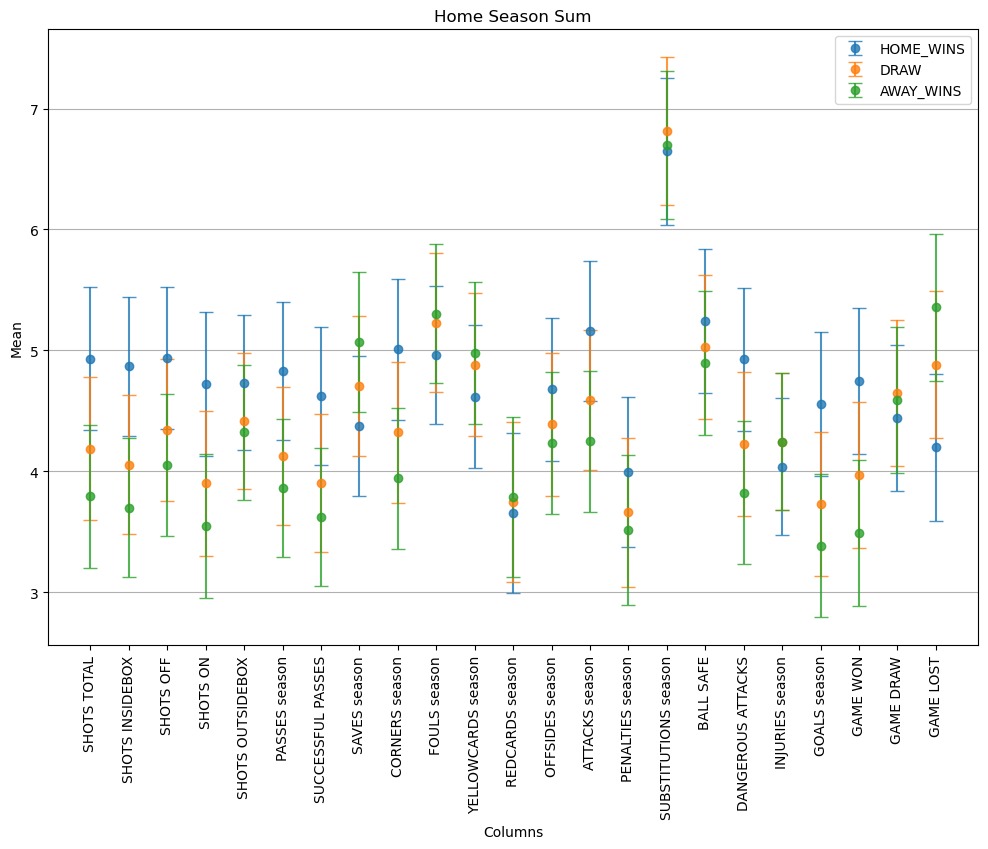

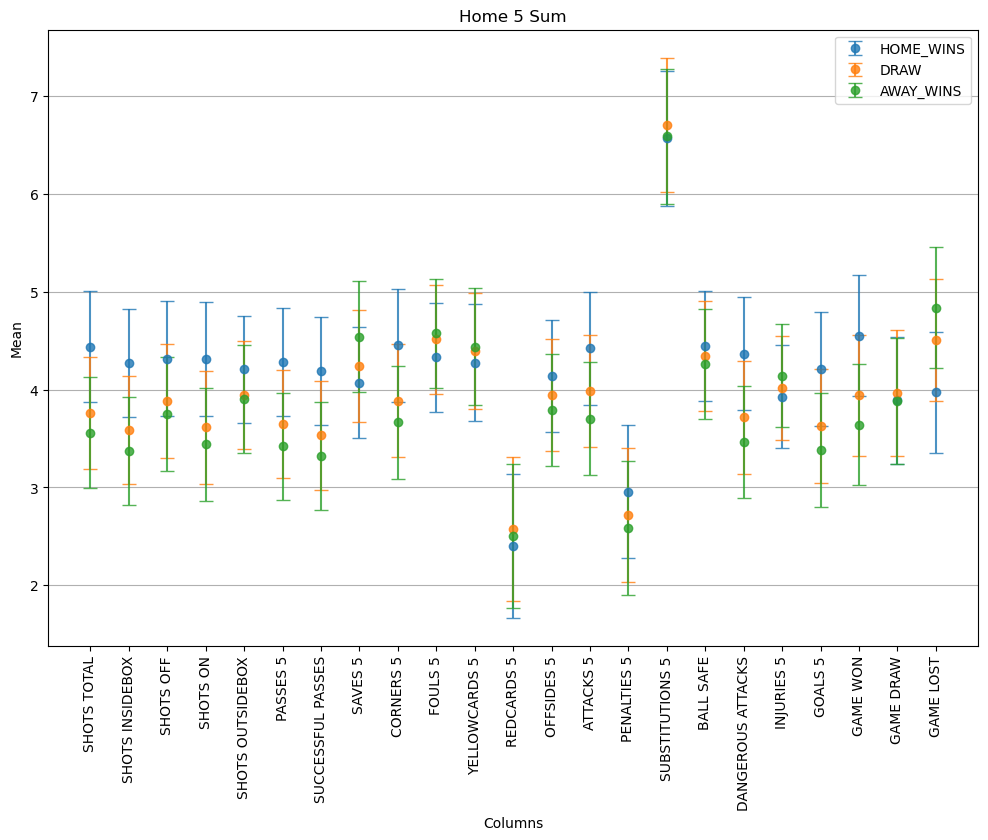

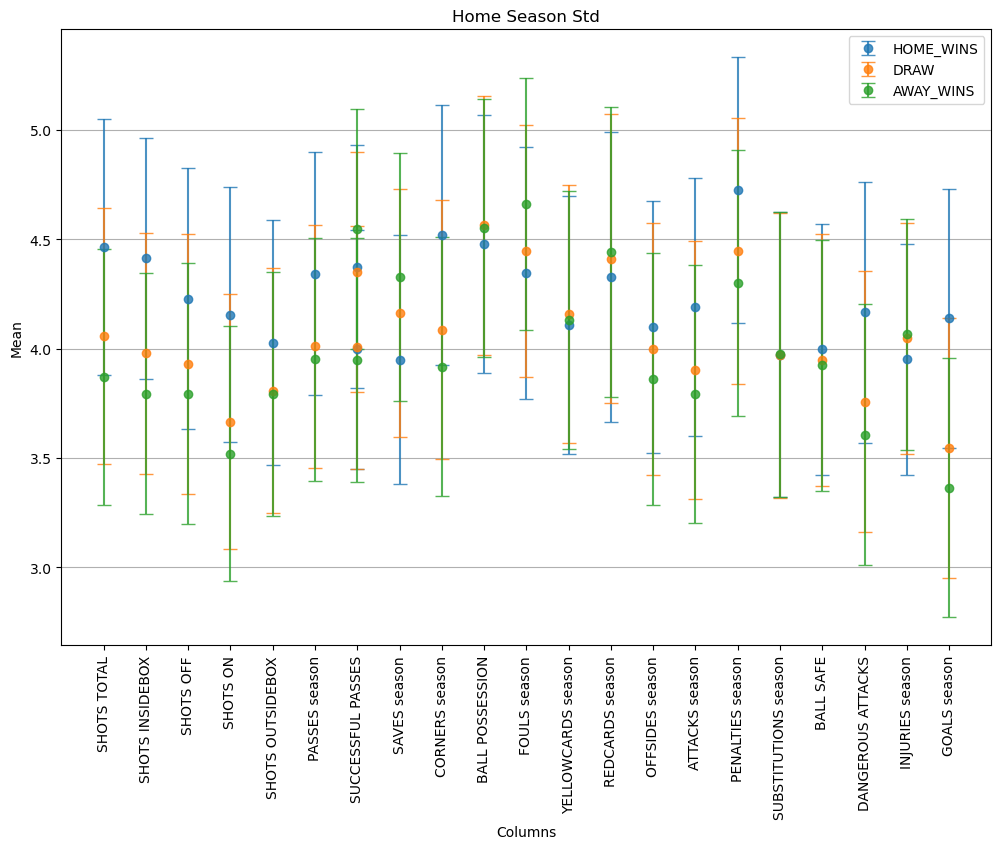

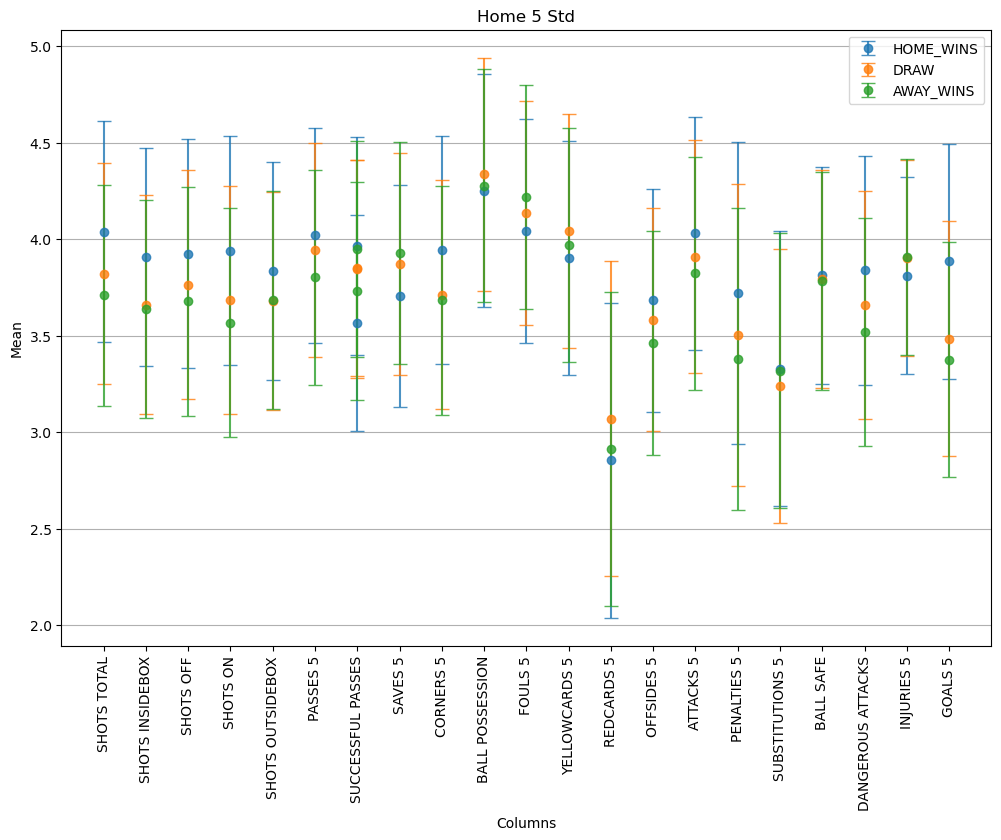

In [16]:
plot_means_and_err(train_home_col_sum_season, "Home Season Sum", train_home)
plot_means_and_err(train_home_col_sum_last_5, "Home 5 Sum", train_home)

plot_means_and_err(train_home_col_std_season, "Home Season Std", train_home)
plot_means_and_err(train_home_col_std_last_5, "Home 5 Std", train_home)

From these plots I think we can get rid of 
- Ball Safe (but keep season sum)
- Substitiutions 

#### Away Data

In [17]:
train_away_col_sum = [c for c in train_away.columns if c.split('_')[-1] == 'sum']
train_away_col_std = [c for c in train_away.columns if c.split('_')[-1] == 'std']

train_away_col_sum_season = [c for c in train_away_col_sum if c.split('_')[-2] == 'season']
train_away_col_sum_last_5 = [c for c in train_away_col_sum if c.split('_')[-2] == 'match']

train_away_col_std_season = [c for c in train_away_col_std if c.split('_')[-2] == 'season']
train_away_col_std_last_5 = [c for c in train_away_col_std if c.split('_')[-2] == 'match']

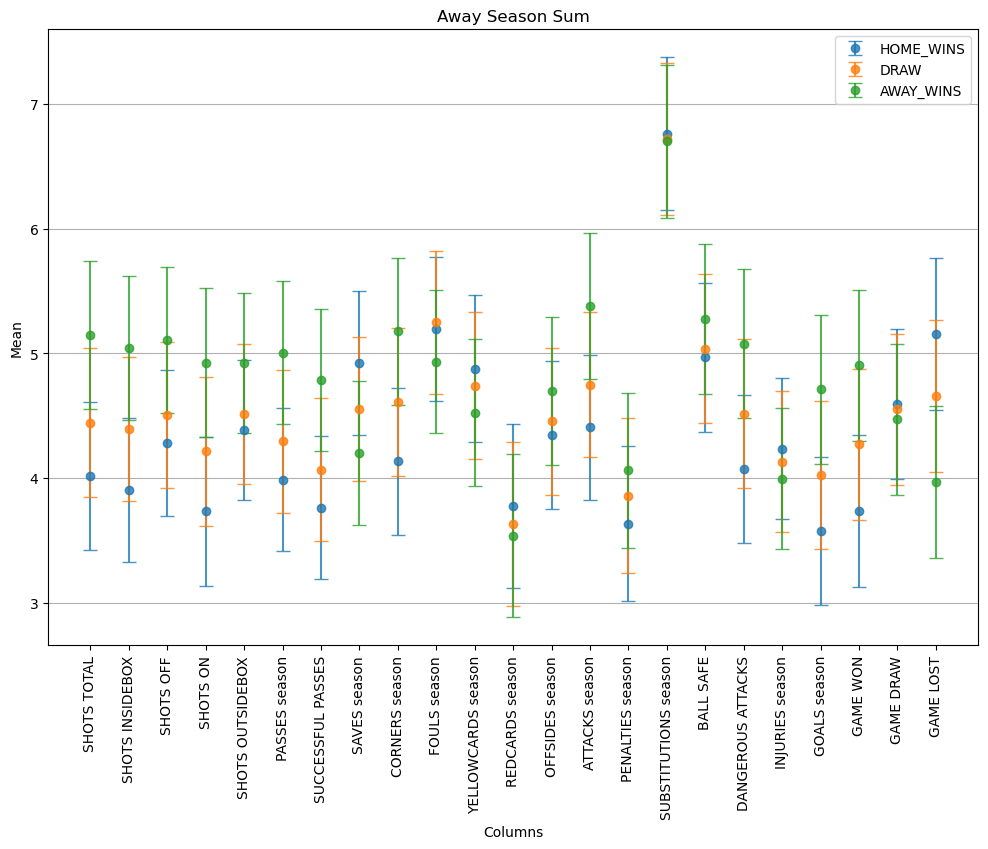

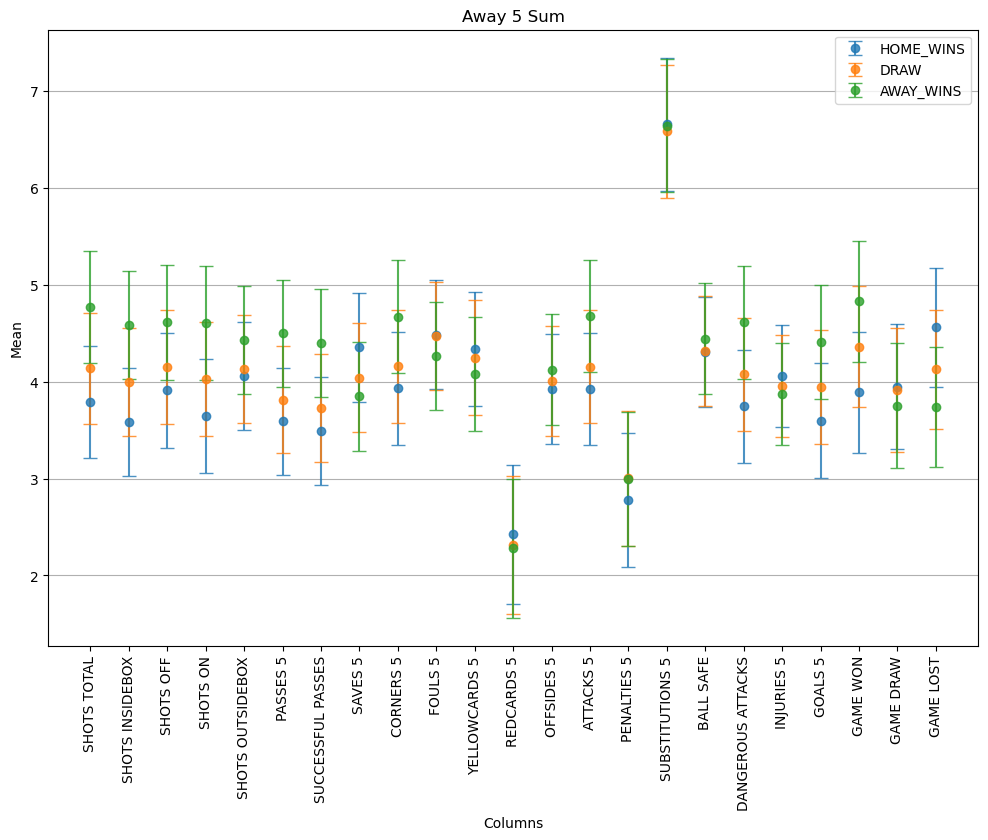

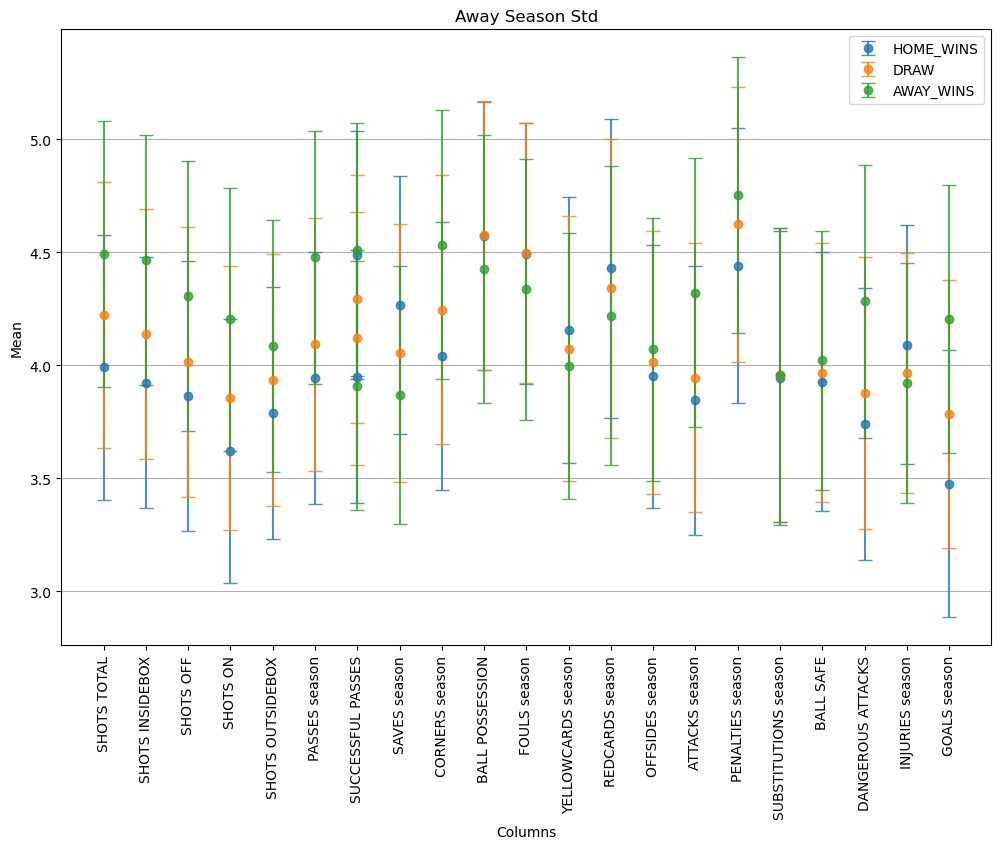

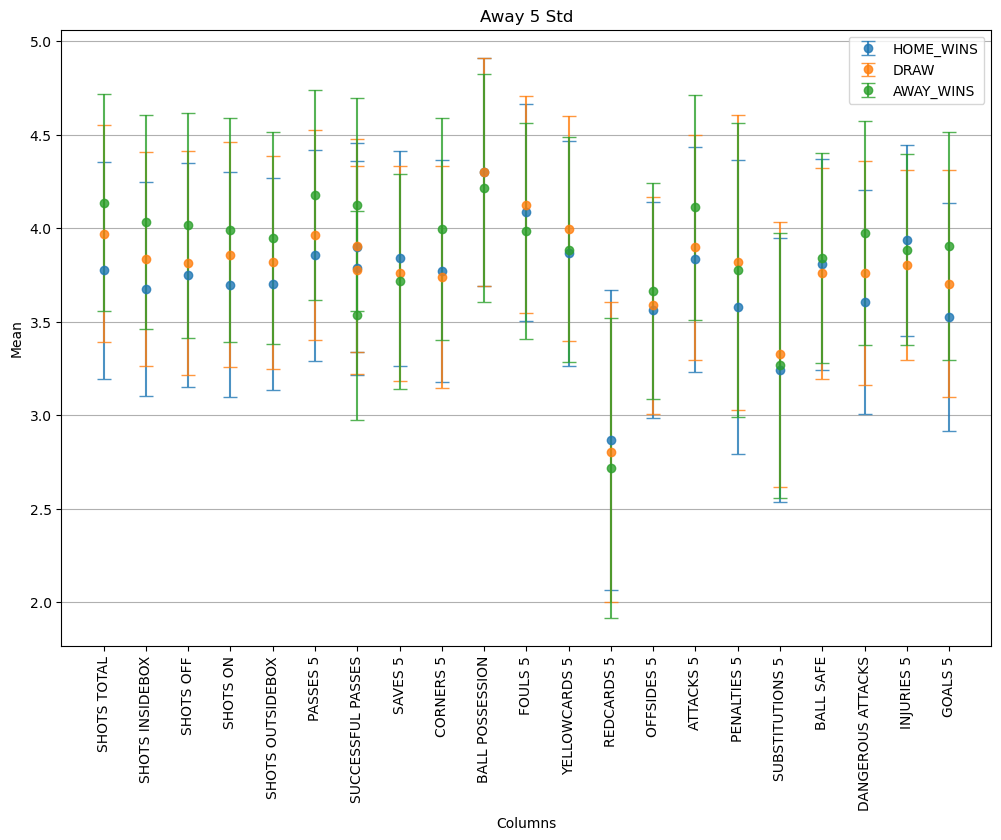

In [18]:
plot_means_and_err(train_away_col_sum_season, "Away Season Sum", train_away)
plot_means_and_err(train_away_col_sum_last_5, "Away 5 Sum", train_away)

plot_means_and_err(train_away_col_std_season, "Away Season Std", train_away)
plot_means_and_err(train_away_col_std_last_5, "Away 5 Std", train_away)

Similar conclusions as to the home data

#### Difference Data

As we want to predict which team wins, it might be intresting to look at the difference of the home and away data frame. We will not include std in this analysis as it doesn't make sense to (the sensible way would be to add the squares and sqaure root)

In [19]:
train_diff = train_home.copy()

train_diff = train_diff.rename(columns={old : new for old, new in zip(train_home.columns, train_away.columns)})
train_diff = train_diff - train_away


new_cols = {old : "DIFF_" + "_".join(old.split('_')[1:]) for old in train_away.columns}
train_diff = train_diff.rename(columns=new_cols)
train_diff = train_diff[[c for c in train_diff.columns if c.split('_')[-1] != 'std']]
# train_diff.columns

In [20]:
train_diff_col_sum = [c for c in train_diff.columns if c.split('_')[-1] == 'sum']
train_diff_col_std = [c for c in train_diff.columns if c.split('_')[-1] == 'std']

train_diff_col_sum_season = [c for c in train_diff_col_sum if c.split('_')[-2] == 'season']
train_diff_col_sum_last_5 = [c for c in train_diff_col_sum if c.split('_')[-2] == 'match']

train_diff_col_std_season = [c for c in train_diff_col_std if c.split('_')[-2] == 'season']
train_diff_col_std_last_5 = [c for c in train_diff_col_std if c.split('_')[-2] == 'match']

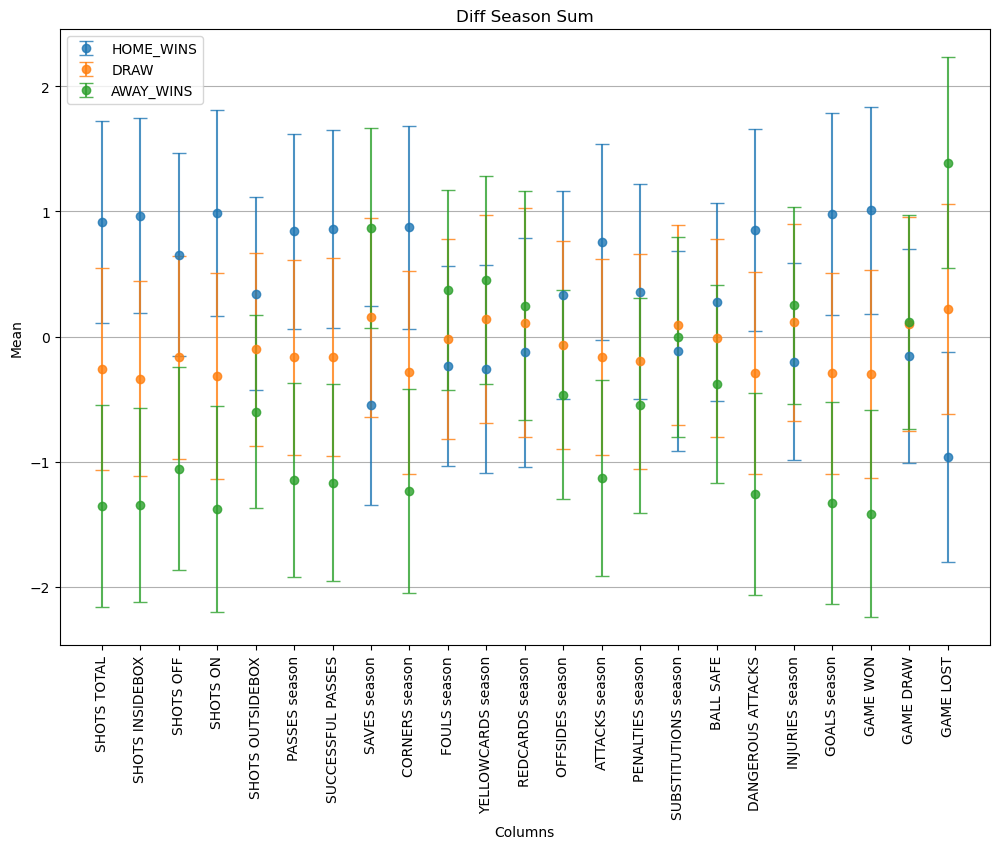

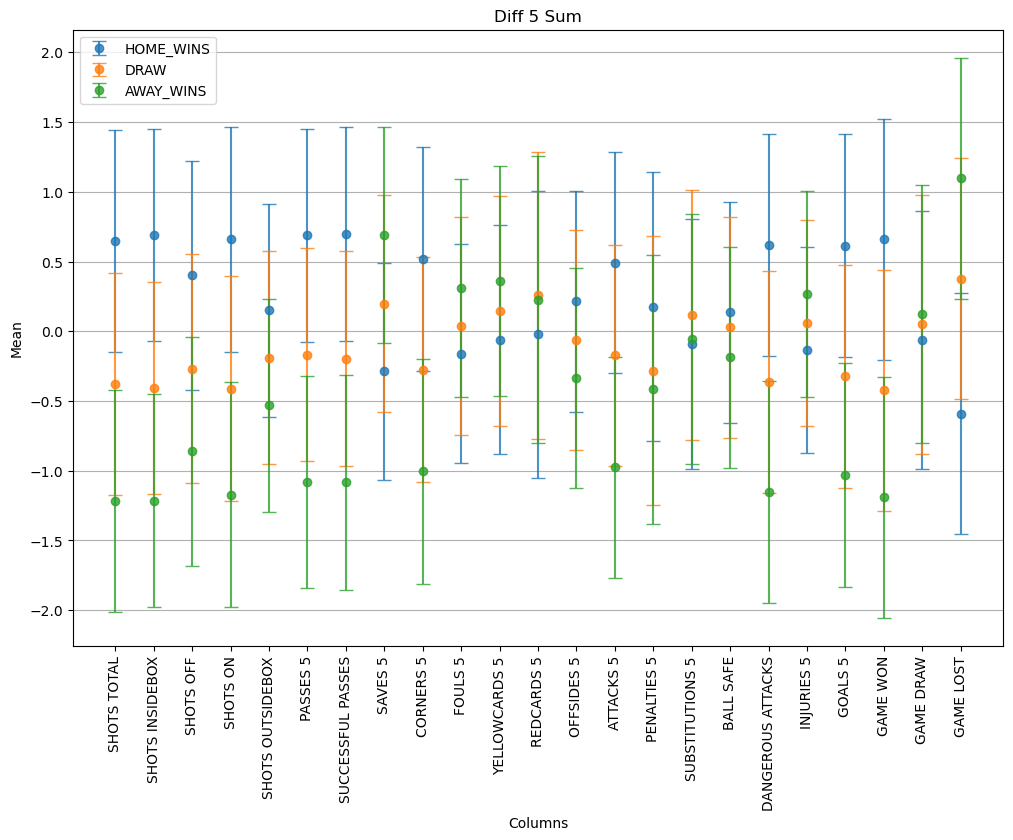

In [21]:
plot_means_and_err(train_diff_col_sum_season, "Diff Season Sum", train_diff)
plot_means_and_err(train_diff_col_sum_last_5, "Diff 5 Sum", train_diff)

I think that this looks like it could be good as a variable. 

### Correlation Data

Lets see if we can plot the correlation of the different variables:

In [22]:
def plot_corr(df, title):
    ax = plt.axes()
    sns.heatmap(df.corr(), ax = ax)
    ax.set_title(title)
    plt.show()

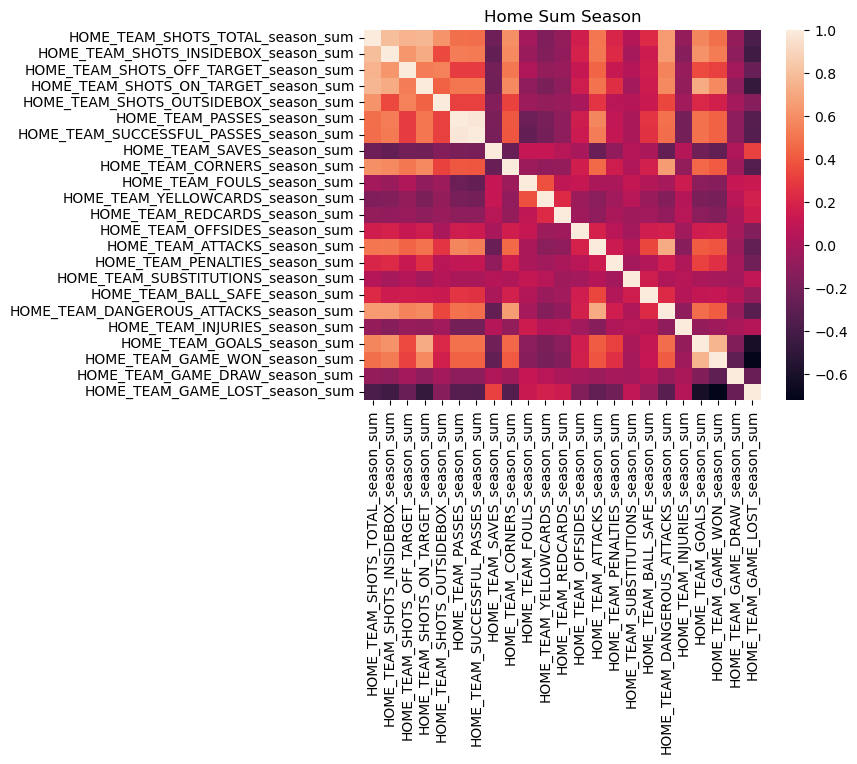

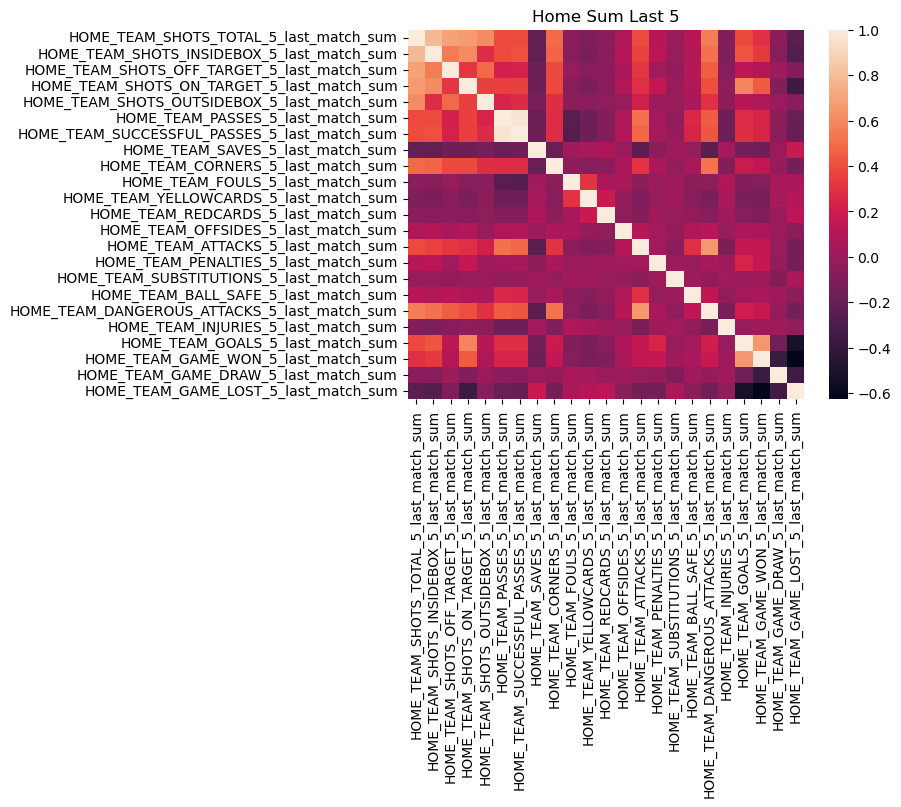

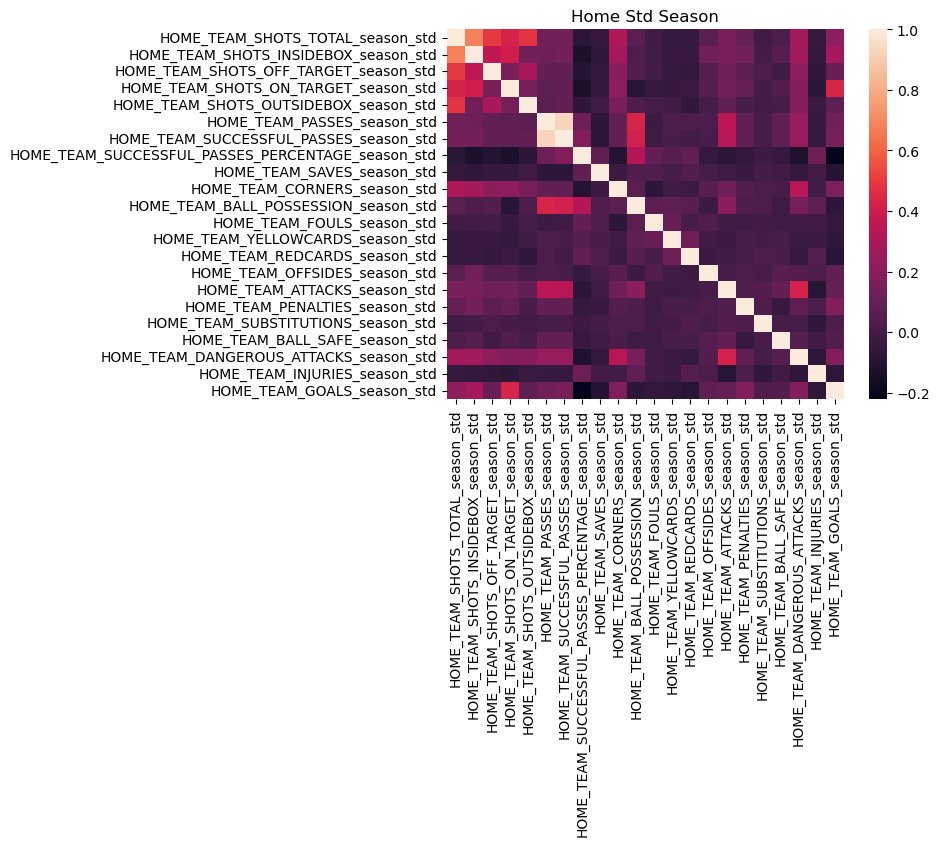

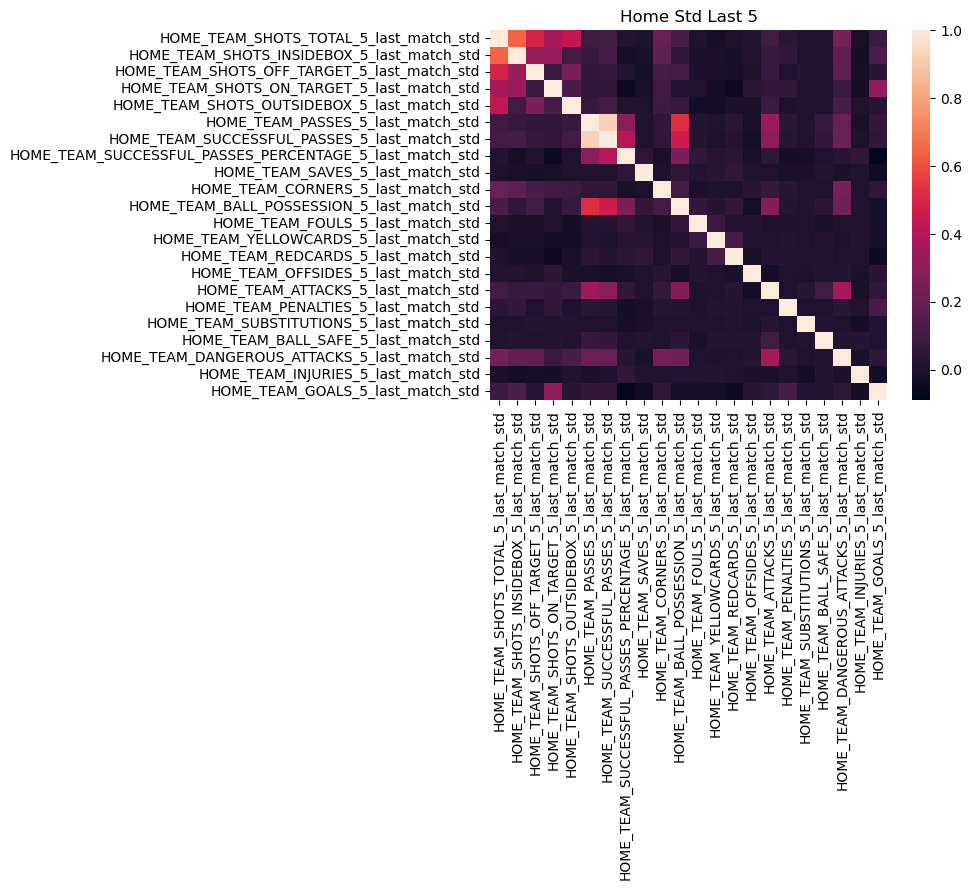

In [23]:
plot_corr(train_home[train_home_col_sum_season], 'Home Sum Season')
plot_corr(train_home[train_home_col_sum_last_5], 'Home Sum Last 5')

plot_corr(train_home[train_home_col_std_season], 'Home Std Season')
plot_corr(train_home[train_home_col_std_last_5], 'Home Std Last 5')

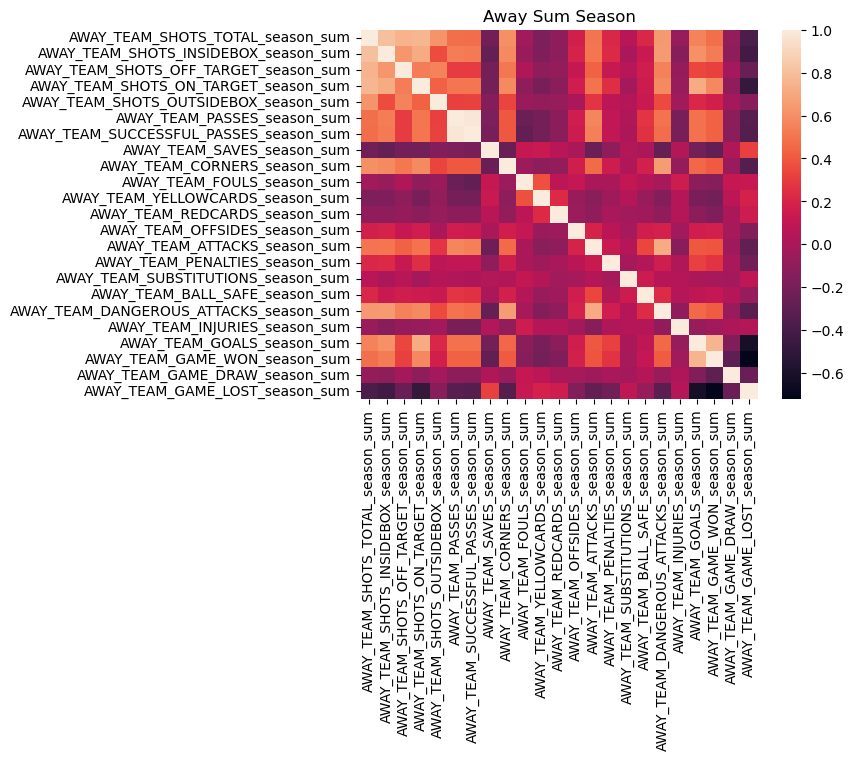

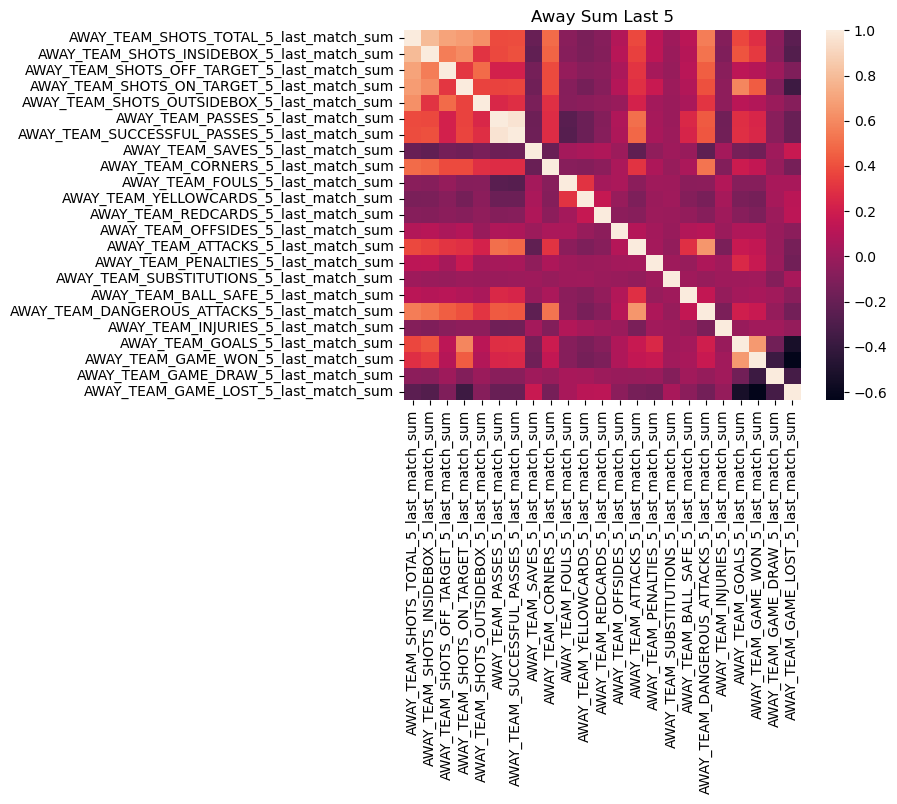

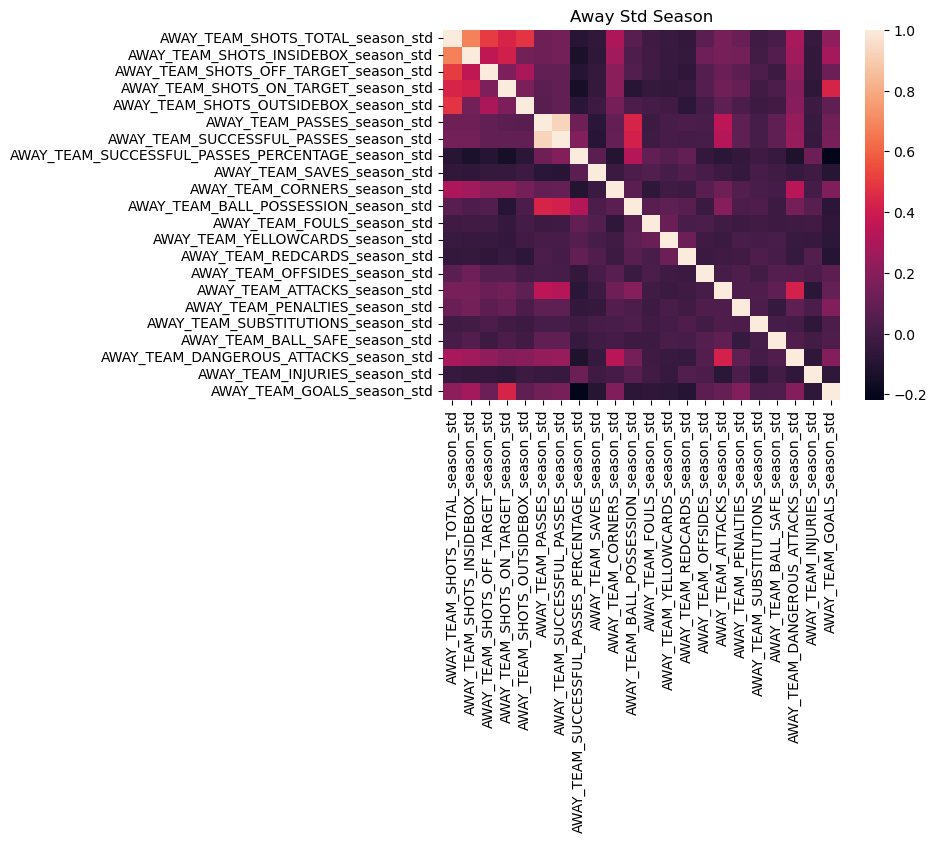

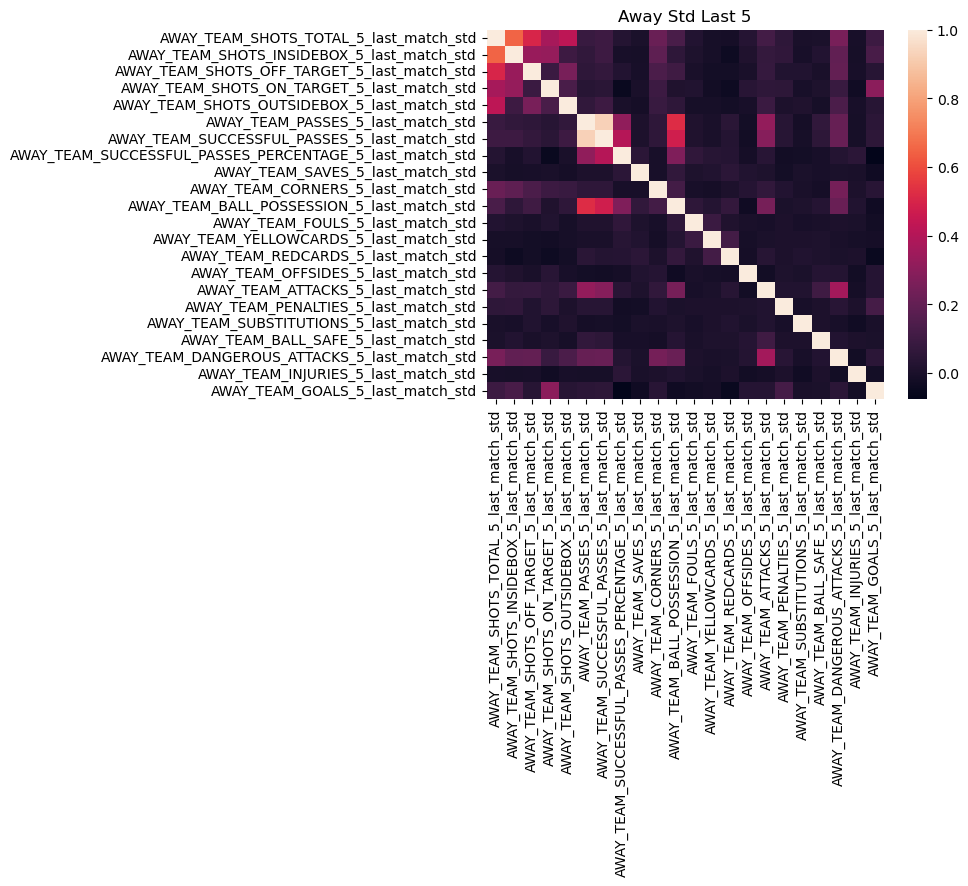

In [24]:
plot_corr(train_away[train_away_col_sum_season], 'Away Sum Season')
plot_corr(train_away[train_away_col_sum_last_5], 'Away Sum Last 5')

plot_corr(train_away[train_away_col_std_season], 'Away Std Season')
plot_corr(train_away[train_away_col_std_last_5], 'Away Std Last 5')

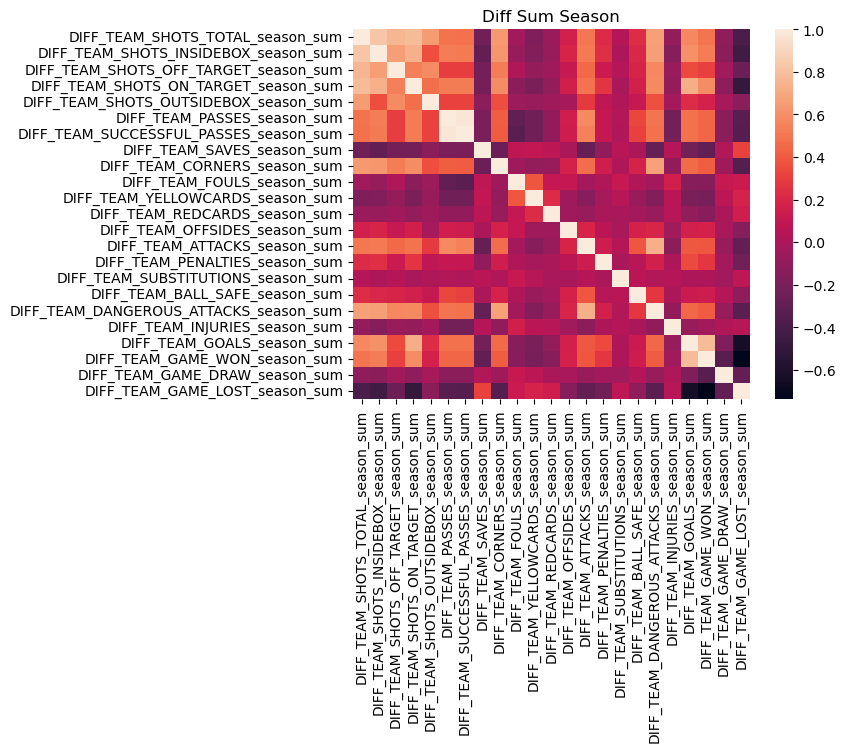

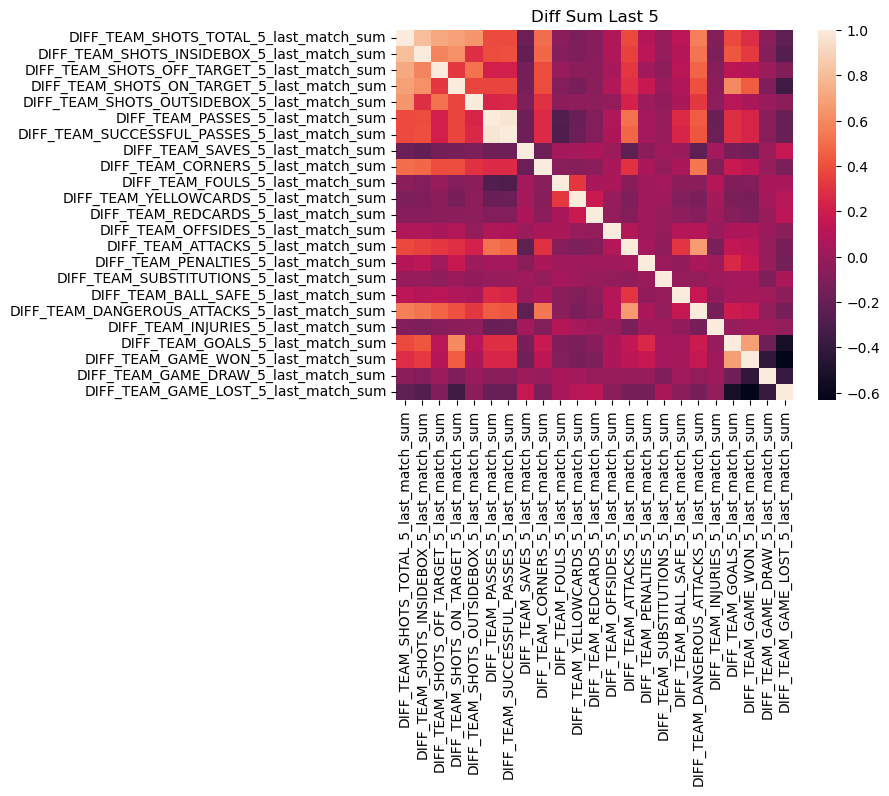

In [25]:
plot_corr(train_diff[train_diff_col_sum_season], 'Diff Sum Season')
plot_corr(train_diff[train_diff_col_sum_last_5], 'Diff Sum Last 5')

We see that the number of passes and the sucessfull number of passes are highly correlated. Therefore we will get rid of sucessful passes.

- `HOME_TEAM_SUCCESSFUL_PASSES_*_*` 

#### Correlation Across Endings

In [26]:
def get_col_zipped_sum_std(col_1, col_2):
    zipped = []
    for c in col_1:
        prefix, suffix = '_'.join(c.split('_')[:-1]), c.split('_')[-1] # We could just index, but this'll do
        to_look_for = prefix + '_std' if suffix == 'sum' else prefix + '_sum'
        if to_look_for in col_2:
            zipped.append([c, to_look_for])
    return zipped

In [27]:
def get_zipped_corr(df, cols_zipped):
    return [df[pair].corr().to_numpy()[0,1] for pair in cols_zipped]

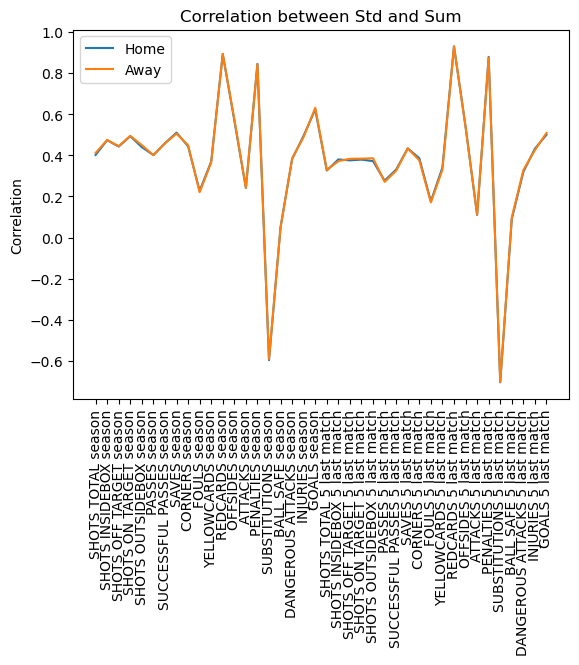

HOME_TEAM_REDCARDS_season_sum 0.8934047076637405
HOME_TEAM_PENALTIES_season_sum 0.8450557794258424
HOME_TEAM_REDCARDS_5_last_match_sum 0.9301247359844472
HOME_TEAM_PENALTIES_5_last_match_sum 0.8791027016160222
HOME_TEAM_SUBSTITUTIONS_5_last_match_sum -0.7049096627243729


In [28]:
train_home_col_zipped_sum_std = get_col_zipped_sum_std(train_home_col_sum, train_home_col_std)
train_away_col_zipped_sum_std = get_col_zipped_sum_std(train_away_col_sum, train_away_col_std)

cols_title = [' '.join(c[0].split('_')[2:-1]) for c in train_home_col_zipped_sum_std]

plt.plot(cols_title, get_zipped_corr(train_home, train_home_col_zipped_sum_std), label = 'Home')
plt.plot(cols_title,get_zipped_corr(train_away, train_away_col_zipped_sum_std), label = 'Away')
    
plt.title('Correlation between Std and Sum')
plt.ylabel('Correlation')
plt.legend()

plt.xticks(rotation=90)
plt.show()

for c, corr in zip(train_home_col_zipped_sum_std, get_zipped_corr(train_home, train_home_col_zipped_sum_std)):
    if abs(corr) > 0.7:
        print(c[0], corr)


Its interesting that the corr is the same between home and away. 
Okay, so I think we are going to get rid of:
- HOME_TEAM_REDCARDS_season_std
- HOME_TEAM_PENALTIES_season_std
- HOME_TEAM_REDCARDS_5_last_match_std
- HOME_TEAM_PENALTIES_5_last_match_std
- HOME_TEAM_SUBSTITUTIONS_5_last_match_std

And there away counterparts

Note, that for some variables there is no sum column as it makes no sense (e.g. percentage of successful passes). In this case don't delete the average. 

#### Correlation Across season and last 5

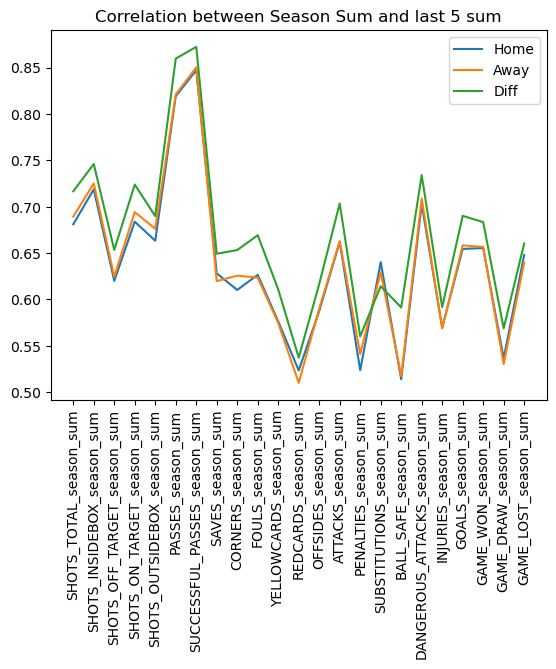

SHOTS_TOTAL_season_sum 0.71666267509898
SHOTS_INSIDEBOX_season_sum 0.7461058071894789
SHOTS_ON_TARGET_season_sum 0.72392856344542
PASSES_season_sum 0.8597936586380085
SUCCESSFUL_PASSES_season_sum 0.8724797311290976
ATTACKS_season_sum 0.7035276667185633
DANGEROUS_ATTACKS_season_sum 0.7341252338154647


In [29]:
train_home_col_sum_zipped_season_5 = [[s, l] for s, l in zip(train_home_col_sum_season,train_home_col_sum_last_5)]
train_away_col_sum_zipped_season_5 = [[s, l] for s, l in zip(train_away_col_sum_season,train_away_col_sum_last_5)]
train_diff_col_sum_zipped_season_5 = [[s, l] for s, l in zip(train_diff_col_sum_season,train_diff_col_sum_last_5)]

cols= [v[10:] for v in train_diff_col_sum_season]
plt.plot(cols, get_zipped_corr(train_home, train_home_col_sum_zipped_season_5), label = 'Home')
plt.plot(cols, get_zipped_corr(train_away, train_away_col_sum_zipped_season_5), label = 'Away')
plt.plot(cols, get_zipped_corr(train_diff, train_diff_col_sum_zipped_season_5), label = 'Diff')
plt.xticks(rotation=90)
plt.title("Correlation between Season Sum and last 5 sum")
plt.legend()
plt.show()
for c, corr in zip(cols, get_zipped_corr(train_diff, train_diff_col_sum_zipped_season_5)):
    if abs(corr) > 0.7:
        print(c, corr)

Due to the high correlation we will get rid of: 

- TEAM_SHOTS_TOTAL_5_last_match_sum
- TEAM_SHOTS_INSIDEBOX_5_last_match_sum
- TEAM_SHOTS_ON_TARGET_5_last_match_sum
- TEAM_PASSES_5_last_match_sum
- TEAM_SUCCESSFUL_PASSES_5_last_match_sum
- TEAM_ATTACKS_5_last_match_sum
- TEAM_DANGEROUS_ATTACKS_5_last_match_sum

from the diff dataset

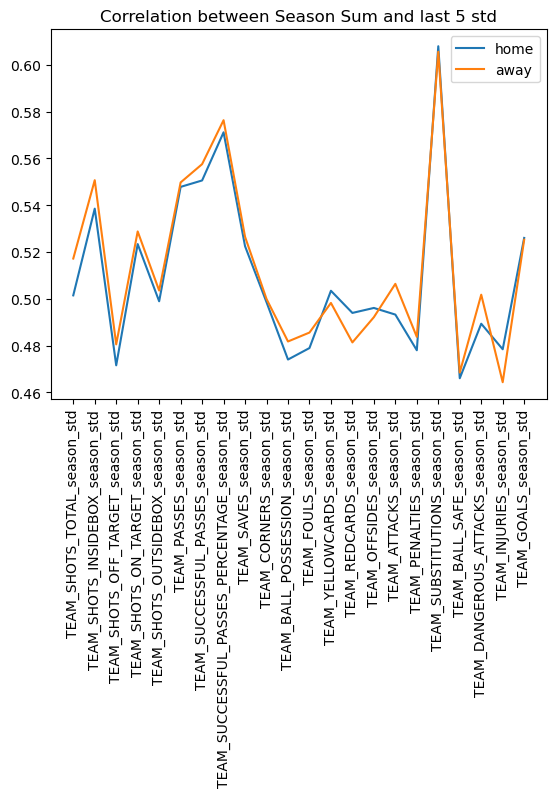

In [30]:
train_away_col_std_zipped_season_5 = [[s, l] for s, l in zip(train_away_col_std_season,train_away_col_std_last_5)]
train_home_col_std_zipped_season_5 = [[s, l] for s, l in zip(train_home_col_std_season,train_home_col_std_last_5)]

cols= [v[5:] for v in train_away_col_std_season]
plt.plot(cols, get_zipped_corr(train_home, train_home_col_std_zipped_season_5), label = 'home')
plt.plot(cols, get_zipped_corr(train_away, train_away_col_std_zipped_season_5), label = 'away')
plt.xticks(rotation=90)
plt.title("Correlation between Season Sum and last 5 std")
plt.legend()
plt.legend()
plt.show()
for c, corr in zip(train_away_col_std_zipped_season_5, get_zipped_corr(train_away, train_away_col_std_zipped_season_5)):
    if abs(corr) > 0.7:
        print(c[0], corr)

None of these are correlated enough so that we can ignore them, but they are fairly well correlated

### Cols to Delete

- Delete all the `TEAM_SUCCESSFUL_PASS`
- Delete all the columns that end with `_average` **apart from** for `TEAM_SUCCESSFUL_PASSES_PERCENTAGE` and `TEAM_BALL_POSSESSION`

## Feature Engineering

### Cleaning For Engineering

We will now combine all the different data set and delete the ones that we don't think are relevant. First we scale the diff data so that it is the same as the rest

In [31]:
def should_keep_col_avg(s):
    if s.split('_')[-1] != 'average':
        return True
    ending = '_'.join(s.split('_')[1:]) 
    if ('TEAM_BALL_POSSESSION' in ending) or ('TEAM_SUCCESSFUL_PASSES_PERCENTAGE' in ending):
        return True
    return False

def remove_averages(df):
    cols_without_avg = [c for c in df.columns if should_keep_col_avg(c)]   
    return df[cols_without_avg].copy()

other_terms_to_keep_sum = { 'TEAM_GAME_DRAW_season', # Keep in absolute value
                'TEAM_GAME_LOST_season', # Keep in absolute value
                'TEAM_GAME_WON_season', # Keep in absolute value
                'TEAM_INJURIES_season'}

def should_keep_remove_sum(s, others_to_keep = other_terms_to_keep_sum):
    split_s = s.split('_')

    for term in others_to_keep:
        if term in s:
            
            return True
    
    if split_s[0] != 'DIFF' and (split_s[-1] == 'sum' or split_s[-1] == 'average'):
        return False
    return True
    
def remove_HOME_AWAY_sums(df):
    cols_without_avg_sum = [c for c in  df.columns if should_keep_remove_sum(c, other_terms_to_keep_sum)]
    return df[cols_without_avg_sum].copy()

def full_removal(df):
    return remove_HOME_AWAY_sums(remove_averages(df))



In [32]:
scaler = MinMaxScaler(feature_range = (0, 10)) # We want it to have the same range, but as a diff I want it to have mean 0

train_diff = pd.DataFrame(scaler.fit_transform(train_diff),columns = train_diff.columns)
train_diff.describe()

train_full = pd.concat([train_data,train_diff],join='inner',axis=1)
train_full.head()

HOME_TEAM_SHOTS_TOTAL_season_sum  HOME_TEAM_SHOTS_INSIDEBOX_season_sum  \
0                               3.0                                   2.0   
1                               6.0                                   8.0   
2                               4.0                                   2.0   
3                               7.0                                   5.0   
4                               3.0                                   3.0   

   HOME_TEAM_SHOTS_OFF_TARGET_season_sum  \
0                                    5.0   
1                                    3.0   
2                                    5.0   
3                                    5.0   
4                                    2.0   

   HOME_TEAM_SHOTS_ON_TARGET_season_sum  \
0                                   2.0   
1                                   6.0   
2                                   2.0   
3                                   6.0   
4                                   3.0   

   HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum  HOME_TEAM_PASSES_season_sum  \
0                                    1.0                          2.0   
1                                    5.0                          8.0   
2                                    8.0                          1.0   
3                                    6.0                          9.0   
4                                    4.0                          4.0   

   HOME_TEAM_SUCCESSFUL_PASSES_season_sum  HOME_TEAM_SAVES_season_sum  \
0                                     2.0                         5.0   
1                                     7.0                        10.0   
2                                     1.0                         2.0   
3                                     9.0                         2.0   
4                                     3.0                         4.0   

   HOME_TEAM_CORNERS_season_sum  HOME_TEAM_FOULS_season_sum  ...  \
0                           3.0                         6.0  ...   
1                           6.0                         8.0  ...   
2                           2.0                         7.0  ...   
3                           2.0                         0.0  ...   
4                           4.0                         7.0  ...   

   DIFF_TEAM_ATTACKS_5_last_match_average  \
0                                     4.0   
1                                     7.5   
2                                     2.5   
3                                     2.5   
4                                     3.0   

   DIFF_TEAM_PENALTIES_5_last_match_average  \
0                                       5.0   
1                                       7.5   
2                                       7.5   
3                                       7.5   
4                                       2.5   

   DIFF_TEAM_SUBSTITUTIONS_5_last_match_average  \
0                                           5.0   
1                                           8.0   
2                                           7.0   
3                                           8.0   
4                                           3.0   

   DIFF_TEAM_BALL_SAFE_5_last_match_average  \
0                                       7.5   
1                                       7.5   
2                                       3.5   
3                                       7.5   
4                                       6.5   

   DIFF_TEAM_DANGEROUS_ATTACKS_5_last_match_average  \
0                                               5.0   
1                                               4.5   
2                                               3.0   
3                                               2.5   
4                                               4.5   

   DIFF_TEAM_INJURIES_5_last_match_average  \
0                                 6.000000   
1                                 5.000000   
2                                 3.000000   
3                                 5.016482   
4                       

### Engineering

#### Win Prior Metric 

IF we know the number of games each team W/D/L, we can estimate the prob that randomly choose game has a given result. However this also means that the other team must have the appropriate result as well. If we assume that the two events are indep, we can calculate the prior prob of what we expect:
- $\mathbb{P}(W) = \mathbb{P}(HW)\mathbb{P}(AL)$
- $\mathbb{P}(D) = \mathbb{P}(HD)\mathbb{P}(AD)$
- $\mathbb{P}(L) = \mathbb{P}(HL)\mathbb{P}(AW)$

We can estimate the prob of a HW, ... by using
$\mathbb{P}(HW) = N(HW)/(N(HW)+N(HD)+N(HD))$

Obviously this isn't mathematically sound, however hopefully it can capture the probabilty that we expect a given pairing to given a certain result. 

In [33]:
home_matches = train_full[['HOME_TEAM_GAME_WON_season_sum','HOME_TEAM_GAME_DRAW_season_sum','HOME_TEAM_GAME_LOST_season_sum']].sum(axis=1)
away_matches = train_full[['AWAY_TEAM_GAME_WON_season_sum','AWAY_TEAM_GAME_DRAW_season_sum','AWAY_TEAM_GAME_LOST_season_sum']].sum(axis=1)
away_matches.describe()

count    12303.000000
mean        13.441438
std          1.926716
min          7.000000
25%         12.000000
50%         13.000000
75%         15.000000
max         21.000000
dtype: float64

In [34]:
HW = train_full['HOME_TEAM_GAME_WON_season_sum']/home_matches
HD = train_full['HOME_TEAM_GAME_DRAW_season_sum']/home_matches
HL = train_full['HOME_TEAM_GAME_LOST_season_sum']/home_matches

AW = train_full['AWAY_TEAM_GAME_WON_season_sum']/away_matches
AD = train_full['AWAY_TEAM_GAME_DRAW_season_sum']/away_matches
AL = train_full['AWAY_TEAM_GAME_LOST_season_sum']/away_matches

In [35]:
train_full['WIN_PRIOR'] = HW * AL
train_full['DRAW_PRIOR'] = HD * AD
train_full['LOST_PRIOR'] = HL * AW

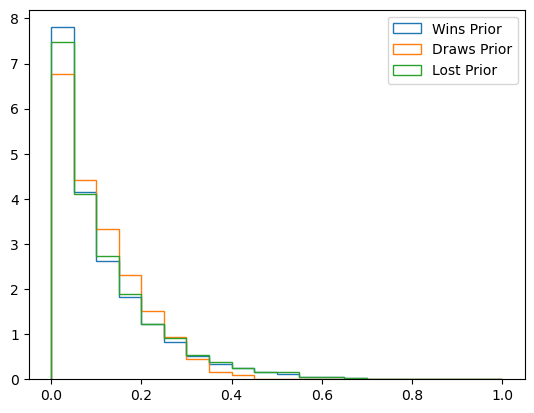

In [36]:
plt.hist(train_full[['WIN_PRIOR']], bins = 20, label = 'Wins Prior', histtype='step', density = True);
plt.hist(train_full[['DRAW_PRIOR']], bins = 20, label = 'Draws Prior', histtype='step', density = True);
plt.hist(train_full[['LOST_PRIOR']], bins = 20, label = 'Lost Prior', histtype='step', density = True);
plt.legend(); 
plt.show()

In [37]:
# We will just put this on the same scale as the other data:
train_full = pd.DataFrame(scaler.fit_transform(train_full),columns = train_full.columns)

#### Win Probability

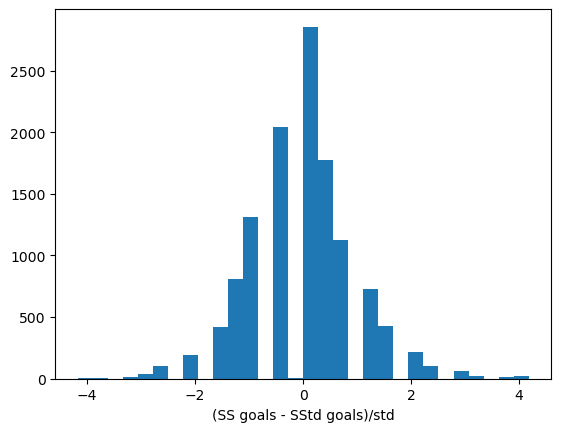

In [38]:
plt.hist((train_data['HOME_TEAM_GOALS_season_average']-train_data['HOME_TEAM_GOALS_season_std'])/(train_data['HOME_TEAM_GOALS_season_average']-train_data['HOME_TEAM_GOALS_season_std']).std(), bins = 30)
plt.xlabel("(SS goals - SStd goals)/std")
plt.show()

We would expect the number of goals to be score by each team to follow a Poisson distribution and from the above plot this seems possible (sum and std) are consistent with being the same. 

If the number of goals scored for each team is $A,H\sim P(\text{H/A Season Sum goals})$, then $H-A\sim\text{Skellam}(\text{HGS, AWS})$. We can use this to get a probability for a win, draw and loss. However to do this we need to estimate the mean number of goals, and hence we need the scaling of the `TEAM_GOALS_season_average` col. 

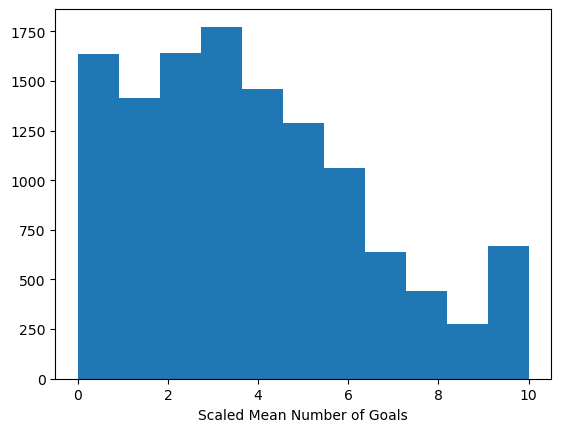

In [39]:
plt.hist(train_full['HOME_TEAM_GOALS_season_average'], bins = 11)
plt.xlabel("Scaled Mean Number of Goals")
plt.show()

As I can't be sure how this scaling is done (and hence I don't know the true varience for the dist), I don't feel confident in using this metric. 

#### Good Shot Feature

We see that all the `SHOT` metrics are highly correlated. We want to reduce the number of features, we will create a 'good shot metric' which will be a quadratic model that aims to predict the number of goals scored. We have four different models to train:

- HOME_GOOD_SHOT_season_sum
- AWAY_GOOD_SHOT_season_sum
- HOME_GOOD_SHOT_5_last_match_sum
- AWAY_GOOD_SHOT_5_last_match_sum

In `good_shot_notebook` we construct a linear model to predict the number of goals scored given the shot data. We find that the same model fits both home and away goals, and works for season and last 5. 

For the last_5 the linear model isn't a great fit due to the large noise and the fact that we are ignoring an important piece (number of saves from the opposite team), however it does provide a handy way to aggregate the different shot metrics. 

##### Saving Shot Data

In [40]:
def get_home_away_cols(cols):
    return [c for c in cols if 'HOME' in c], [c for c in cols if 'AWAY' in c]

In [41]:
home_col, away_col  = get_home_away_cols(train_full.columns)
train_full[home_col].to_csv("Good_Shot_Feature/Home_Data_cleaned.csv")
train_full[away_col].to_csv("Good_Shot_Feature/Away_Data_cleaned.csv")

We now turn to `Good_Shot_Feature.ipynb` to fit the shot data

##### Creating Good Shot Features

Now that we have the model, we can generate the new feature. 

In [42]:
with open('Good_Shot_Feature/good_shot_model.pkl', 'rb') as file:
    good_shot_model = pickle.load(file)

In [43]:
def get_good_shot_col(cols, HorA, Sor5):
    return [c for c in cols if (HorA in c and Sor5 in c and 'SHOT' in c and 'sum' in c)]

home_shot_season = get_good_shot_col(train_full.columns, 'HOME', 'season')
home_shot_5 = get_good_shot_col(train_full.columns, 'HOME', '5_last_match')

away_shot_season = get_good_shot_col(train_full.columns, 'AWAY', 'season')
away_shot_5 = get_good_shot_col(train_full.columns, 'AWAY', '5_last_match')

In [44]:
train_full['HOME_GOOD_SHOT_season_sum'] = good_shot_model.predict(train_full[home_shot_season])
train_full['HOME_GOOD_SHOT_5_last_match_sum'] = good_shot_model.predict(train_full[home_shot_5])
train_full['AWAY_GOOD_SHOT_season_sum'] = good_shot_model.predict(train_full[away_shot_season])
train_full['AWAY_GOOD_SHOT_5_last_match_sum'] = good_shot_model.predict(train_full[away_shot_5])

In [45]:
train_full['DIFF_GOOD_SHOT_season_sum'] = train_full['HOME_GOOD_SHOT_season_sum'] - train_full['AWAY_GOOD_SHOT_season_sum']
train_full['DIFF_GOOD_SHOT_5_last_match_sum'] = train_full['HOME_GOOD_SHOT_5_last_match_sum'] - train_full['AWAY_GOOD_SHOT_5_last_match_sum']

In [46]:
train_full = pd.DataFrame(scaler.fit_transform(train_full), columns = train_full.columns)
train_full[['HOME_GOOD_SHOT_season_sum', 'AWAY_GOOD_SHOT_season_sum', 'DIFF_GOOD_SHOT_season_sum']].head()

HOME_GOOD_SHOT_season_sum  AWAY_GOOD_SHOT_season_sum  \
0                   3.055047                   2.103848   
1                   6.426984                   3.280746   
2                   2.443140                   2.950589   
3                   5.558157                   1.910846   
4                   3.810241                   5.313834   

   DIFF_GOOD_SHOT_season_sum  
0                   5.475600  
1                   6.573119  
2                   4.746275  
3                   6.823656  
4                   4.248204

#### Form Metric 

To calculate the form, we first create a form score, which is a linear combination of the sum of wins, draws and losses with wiegths 2,1,0 respectively. 

We then fit a lasso model and a forward stepwise linear model to get the relevent features. The model fit okay, but are not brilliant. They have a $R^2\approx0.4$ and the test and training MSE are v similar so I imagine that are model just isn't rich enough. 

We combine the following features together into a 'FORM' metric
- TEAM_GOALS_5_last_match_sum
- TEAM_SAVES_5_last_match_sum
- TEAM_SHOTS_ON_TARGET_5_last_match_sum
- TEAM_GOALS_5_last_match_std
- TEAM_REDCARDS_5_last_match_sum

In [47]:
with open('Form_Feature/form_model.pkl', 'rb') as file:
    form_model = pickle.load(file)

form_features = pd.read_csv('Form_Feature/form_features.csv')['Feature'].to_list()
away_form_features = ['AWAY_'+f for f in form_features]
home_form_features = ['HOME_'+f for f in form_features]

We have to rename the columns when we do the predictions because the model's feature names don't have the 'HOME' or 'AWAY' part

In [48]:
train_full['AWAY_FORM_5_last_match_sum'] = form_model.predict(train_full[away_form_features].rename(columns = {o : n for o, n in zip(away_form_features, form_features)}))
train_full['HOME_FORM_5_last_match_sum'] = form_model.predict(train_full[home_form_features].rename(columns = {o : n for o, n in zip(home_form_features, form_features)}))
train_full['DIFF_FORM_5_last_match_sum'] = train_full['HOME_FORM_5_last_match_sum']-train_full['AWAY_FORM_5_last_match_sum']

In [49]:
train_full = pd.DataFrame(scaler.fit_transform(train_full), columns = train_full.columns)
train_full[['HOME_FORM_5_last_match_sum', 'AWAY_FORM_5_last_match_sum', 'DIFF_FORM_5_last_match_sum']].head()

HOME_FORM_5_last_match_sum  AWAY_FORM_5_last_match_sum  \
0                    4.919972                    4.064975   
1                    8.637843                    2.778027   
2                    3.886070                    1.824701   
3                    6.356734                    3.772008   
4                    4.120604                    7.573948   

   DIFF_FORM_5_last_match_sum  
0                    5.457181  
1                    8.007656  
2                    6.026174  
3                    6.342259  
4                    3.318587

#### Estimate Goal Diff

An import task when fitting will be to limit overfitting. As such we want to make some summary metrics (this is what we've done in the previous two sections). When we have done this, we have trained our linear models by using other things in our data set that will track if the team wins or looses. 

For this final one, we will try and predict the goal diff. Obviously this is different to our real training aim, but with correlate with it very strongly.

In [50]:
train_full = pd.DataFrame(scaler.fit_transform(train_full), columns = train_full.columns)
full_removal(train_full).to_csv('Goal_Diff_Prediction/GD_training_data.csv') # Saves the data set we want to model with
full_removal(train_full).head()

HOME_TEAM_INJURIES_season_sum  HOME_TEAM_GAME_WON_season_sum  \
0                            0.0                            1.0   
1                            2.0                            8.0   
2                            8.0                            1.0   
3                            0.0                            6.0   
4                            4.0                            2.0   

   HOME_TEAM_GAME_DRAW_season_sum  HOME_TEAM_GAME_LOST_season_sum  \
0                             6.0                            10.0   
1                             4.0                             1.0   
2                             2.0                             8.0   
3                            10.0                             0.0   
4                             9.0                             4.0   

   HOME_TEAM_SHOTS_TOTAL_season_std  HOME_TEAM_SHOTS_INSIDEBOX_season_std  \
0                               5.0                                   4.0   
1                               4.0                                   3.0   
2                               6.0                                   6.0   
3                               5.0                                   8.0   
4                               5.0                                   1.0   

   HOME_TEAM_SHOTS_OFF_TARGET_season_std  \
0                                    3.0   
1                                    1.0   
2                                    7.0   
3                                    7.0   
4                                    1.0   

   HOME_TEAM_SHOTS_ON_TARGET_season_std  \
0                                   5.0   
1                                   5.0   
2                                   5.0   
3                                   4.0   
4                                   2.0   

   HOME_TEAM_SHOTS_OUTSIDEBOX_season_std  HOME_TEAM_PASSES_season_std  ...  \
0                                    3.0                         10.0  ...   
1                                    6.0                          1.0  ...   
2                                    5.0                          4.0  ...   
3                                    4.0                          5.0  ...   
4                                    7.0                          3.0  ...   

   DIFF_TEAM_GAME_DRAW_5_last_match_sum  DIFF_TEAM_GAME_LOST_5_last_match_sum  \
0                                   5.0                                   7.5   
1                                   5.0                                   1.5   
2                                   4.0                                   5.0   
3                                   6.5                                   1.5   
4                                   6.5                                   5.0   

   DIFF_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_5_last_match_average  \
0                                                3.0             
1                                                4.5             
2                                                3.5             
3                                                5.5             
4                                                4.5             

   DIFF_TEAM_BALL_POSSESSION_5_last_match_average  WIN_PRIOR  DRAW_PRIOR  \
0                                             3.5   0.000000    2.171946   
1                                             5.0   3.786982    0.946746   
2                                             3.0   0.378788    0.757576   
3                                             6.0   1.875000    2.604167   
4                                             3.5   0.484848    1.090909   

   LOST_PRIOR  DIFF_GOOD_SHOT_season_sum  DIFF_GOOD_SHOT_5_last_match_sum  \
0    2.262443                   5.475600                         5.389549   
1    0.059172                   6.573119                         6.577667   
2    1.212121                   4.746275                         6.230042   
3    0.000000                   6.823656                         6.096145   
4  

In [51]:
with open('goal_diff_prediction/normal_sampled_DG_predictor.pkl', 'rb') as file:
    normal_sampled_GD_model = pickle.load(file)

In [52]:
GD_features = pd.read_csv('goal_diff_prediction/Features.csv')['Feature'].to_list()

In [53]:
train_full['NORMAL_SAMPLED_PREDICTED_GD'] = normal_sampled_GD_model.predict(train_full[GD_features])

In [54]:
train_full['NORMAL_SAMPLED_PREDICTED_GD'].describe()

count    12303.000000
mean         0.268311
std          0.636941
min         -1.672190
25%         -0.120477
50%          0.264102
75%          0.650274
max          2.715688
Name: NORMAL_SAMPLED_PREDICTED_GD, dtype: float64

In [55]:
train_full = pd.DataFrame(scaler.fit_transform(train_full),columns = train_full.columns)

## Saving Data Sets

Now that we have cleaned and generated the new features, we save all the data:

In [56]:
train_without_avg_sum = full_removal(train_full)
train_without_avg_sum.to_csv('WL_Model/WL_train.csv', index = False)
train_without_avg_sum.head()

HOME_TEAM_INJURIES_season_sum  HOME_TEAM_GAME_WON_season_sum  \
0                            0.0                            1.0   
1                            2.0                            8.0   
2                            8.0                            1.0   
3                            0.0                            6.0   
4                            4.0                            2.0   

   HOME_TEAM_GAME_DRAW_season_sum  HOME_TEAM_GAME_LOST_season_sum  \
0                             6.0                            10.0   
1                             4.0                             1.0   
2                             2.0                             8.0   
3                            10.0                             0.0   
4                             9.0                             4.0   

   HOME_TEAM_SHOTS_TOTAL_season_std  HOME_TEAM_SHOTS_INSIDEBOX_season_std  \
0                               5.0                                   4.0   
1                               4.0                                   3.0   
2                               6.0                                   6.0   
3                               5.0                                   8.0   
4                               5.0                                   1.0   

   HOME_TEAM_SHOTS_OFF_TARGET_season_std  \
0                                    3.0   
1                                    1.0   
2                                    7.0   
3                                    7.0   
4                                    1.0   

   HOME_TEAM_SHOTS_ON_TARGET_season_std  \
0                                   5.0   
1                                   5.0   
2                                   5.0   
3                                   4.0   
4                                   2.0   

   HOME_TEAM_SHOTS_OUTSIDEBOX_season_std  HOME_TEAM_PASSES_season_std  ...  \
0                                    3.0                         10.0  ...   
1                                    6.0                          1.0  ...   
2                                    5.0                          4.0  ...   
3                                    4.0                          5.0  ...   
4                                    7.0                          3.0  ...   

   DIFF_TEAM_GAME_LOST_5_last_match_sum  \
0                                   7.5   
1                                   1.5   
2                                   5.0   
3                                   1.5   
4                                   5.0   

   DIFF_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_5_last_match_average  \
0                                                3.0             
1                                                4.5             
2                                                3.5             
3                                                5.5             
4                                                4.5             

   DIFF_TEAM_BALL_POSSESSION_5_last_match_average  WIN_PRIOR  DRAW_PRIOR  \
0                                             3.5   0.000000    2.171946   
1                                             5.0   3.786982    0.946746   
2                                             3.0   0.378788    0.757576   
3                                             6.0   1.875000    2.604167   
4                                             3.5   0.484848    1.090909   

   LOST_PRIOR  DIFF_GOOD_SHOT_season_sum  DIFF_GOOD_SHOT_5_last_match_sum  \
0    2.262443                   5.475600                         5.389549   
1    0.059172                   6.573119                         6.577667   
2    1.212121                   4.746275                         6.230042   
3    0.000000                   6.823656                         6.096145   
4    1.212121                   4.248204                         2.951824   

   DIFF_FORM_5_last_match_sum  NORMAL_SAMPLED_PREDICTED_GD  
0                    5.457181                     3.297956  
1                    8.007656  

In [57]:
df = create_processed_training_df('Train_Data/train_home_team_statistics_df.csv', 'Train_Data/train_away_team_statistics_df.csv', True)
df.head()





HOME_TEAM_INJURIES_season_sum  HOME_TEAM_GAME_WON_season_sum  \
0                            0.0                            1.0   
1                            2.0                            8.0   
2                            8.0                            1.0   
3                            0.0                            6.0   
4                            4.0                            2.0   

   HOME_TEAM_GAME_DRAW_season_sum  HOME_TEAM_GAME_LOST_season_sum  \
0                             6.0                            10.0   
1                             4.0                             1.0   
2                             2.0                             8.0   
3                            10.0                             0.0   
4                             9.0                             4.0   

   HOME_TEAM_SHOTS_TOTAL_season_std  HOME_TEAM_SHOTS_INSIDEBOX_season_std  \
0                               5.0                                   4.0   
1                               4.0                                   3.0   
2                               6.0                                   6.0   
3                               5.0                                   8.0   
4                               5.0                                   1.0   

   HOME_TEAM_SHOTS_OFF_TARGET_season_std  \
0                                    3.0   
1                                    1.0   
2                                    7.0   
3                                    7.0   
4                                    1.0   

   HOME_TEAM_SHOTS_ON_TARGET_season_std  \
0                                   5.0   
1                                   5.0   
2                                   5.0   
3                                   4.0   
4                                   2.0   

   HOME_TEAM_SHOTS_OUTSIDEBOX_season_std  HOME_TEAM_PASSES_season_std  ...  \
0                                    3.0                         10.0  ...   
1                                    6.0                          1.0  ...   
2                                    5.0                          4.0  ...   
3                                    4.0                          5.0  ...   
4                                    7.0                          3.0  ...   

   DIFF_TEAM_GOALS_5_last_match_sum  DIFF_TEAM_GAME_WON_5_last_match_sum  \
0                               2.0                             4.500000   
1                               4.0                             4.500000   
2                               4.0                             6.500000   
3                               6.5                             5.001758   
4                               5.5                             4.000000   

   DIFF_TEAM_GAME_DRAW_5_last_match_sum  DIFF_TEAM_GAME_LOST_5_last_match_sum  \
0                                   3.5                                   6.0   
1                                   9.0                                   6.0   
2                                   5.5                                   4.0   
3                                   7.0                                   3.0   
4                                   0.0                                   3.5   

   DIFF_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_5_last_match_average  \
0                                                4.0             
1                                                4.0             
2                                                3.5             
3                                                5.0             
4                                                5.0             

   DIFF_TEAM_BALL_POSSESSION_5_last_match_average  DIFF_GOOD_SHOT_season_sum  \
0                                             3.5                        6.0   
1                                             5.0                        7.0   
2                                             3.5                        7.0   
3                                             5.0                   

## Conclusion

We have done the initial data exploration and feature engineering in this notebook in particular, we noted:

- There are many highly correlated different features. To overcome this, we
    - created 'difference' features, that was the HOME - AWAY values.
    - Removed the mean column (where correlation was around .90)
- Where possible we filled in missing values by taking from others in the team data, e.g. taking last 5 injuries from the season injuries. For all other values we imputed the mean of that column
- Feature Creation:
    - Prior feature: an estimate of the prob that we select a W/D/L from the season of each team that it happens to be this game.
    - Good Shot metric: we try to remove noise from all the shot data, by linearlly fitting the total goal total with all the different shot metrics
    - Form Metric: we regress on a target made by summing 0*last_5_losses +1*last_5_draws+2*last_5_wins, tryng to capture how inform the team is
    - Predicted GD: we use the supp file to predict the goal diff for each game. We use the standard data set and one that we upsample inorder to better predict the games with a larger goal differerence. Its worth noting that the first approach gets more scores correct, however the second gets more games correct. This makes sense as the first predicts many draws.  